Note: Code should be run in a FBL Medulla kernel

In [9]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import networkx
import numpy as np
import os.path
from random import choice
import tempfile
import typing as tp
import flybrainlab as fbl

import linecache
import os
import tracemalloc

import netpyne
from netpyne.specs import netParams, SimConfig
from netpyne import conversion, sim

from brian2 import *

import package.nlpToNetpyne as toNet
import package.nlptoBrian2 as toBri

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Helper Functions / Variables

In [10]:
def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))
    
queries = ['show column C',
           'show column A and column C',
           'show column A and column B and column C',
           'show column A and column B and column C and column D',
           'show column A and column B and column C and column D and column E',
           'show column A and column B and column C and column D and column E and column F']

labels = ['Column_C',
          'Columns_A_C',
          'Columns_A_B_C',
          'Columns_A_B_C_D',
          'Columns_A_B_C_D_E',
          'Columns_A_B_C_D_E_F']

## NetPyNE

In [10]:
stim_mech = {'bkg': {'type': 'NetStim', 'rate': 10, 'noise': 0}} # Stimulation mechanism
default_syn = {'mod': 'Exp2Syn', 'tau1': 0.1, 'tau2': 5.0, 'e': 0} # Excitatory synapse mechanism


default_cell = {'secs': {}}
default_cell['secs']['soma'] = {'geom': {}, 'mechs': {}}
default_cell['secs']['soma']['geom'] = {'diam': 18.8, 'L': 18.8, 'Ra': 123.0}                           # soma geometry
default_cell['secs']['soma']['mechs']['hh'] = {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -70}  # soma hh mechanism

my_client = fbl.get_client()

for i, query in enumerate(queries):
    res = my_client.executeNLPquery(query)
    
    networkParameters, simConfig = toNet.model_gen(client=my_client,
                                                   res=res,
                                                   filename=labels[i],
                                                   default_mech=default_syn,
                                                   default_cell=default_cell,
                                                   stim_sources=stim_mech,
                                                   stim_targets={'Mi4_C': {'source': 'bkg', 'weight': 0.5, 'delay': 1, 'mech': 'exc'}},
                                                   record_names=['L2_C', 'C2_C', 'Mi4_C'],
                                                   maintain_morphology=False)
    
    tracemalloc.start()
    
    print("Simulating query: " + query)

    toNet.simulate(networkParameters, simConfig)

    snapshot = tracemalloc.take_snapshot()
    display_top(snapshot)

    tracemalloc.stop()

[FBL NLP 2023-07-24 07:56:02,299] NLP successfully parsed query.
Simulating query: show column C

Start time:  2023-07-24 07:56:21.004850

Creating network of 37 cell populations on 1 hosts...
  Number of cells on node 0: 37 
  Done; cell creation time = 0.02 s.
Making connections...
  Number of connections on node 0: 281 
  Done; cell connection time = 0.12 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 3 traces of 1 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 0.44 s; real-time ratio: 2.28.

Gathering data...
  Done; gather time = 0.03 s.

Analyzing...
  Cells: 37
  Connections: 282 (7.62 per cell)
  Spikes: 350 (9.46 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 0.44 s
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... cell
Plotting 2D representation of network cell locations and connections...
Plotting connectivity matrix...
  Done; plotting time = 2.75 s


## Brian2

[FBL NLP 2023-07-28 08:07:12,183] NLP successfully parsed query.


WARNING    Cannot use Cython, a test compilation failed: command 'cl.exe' failed: None (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Simulating query: show column C


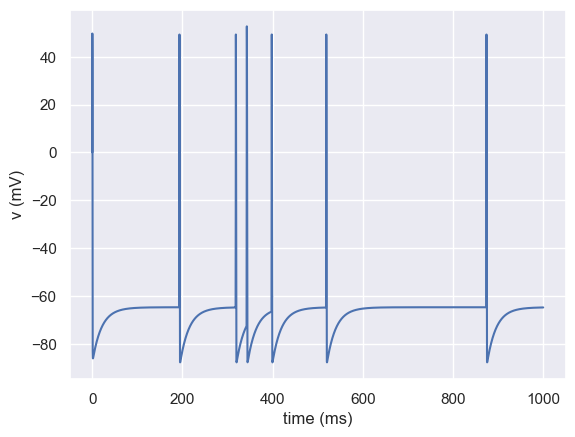

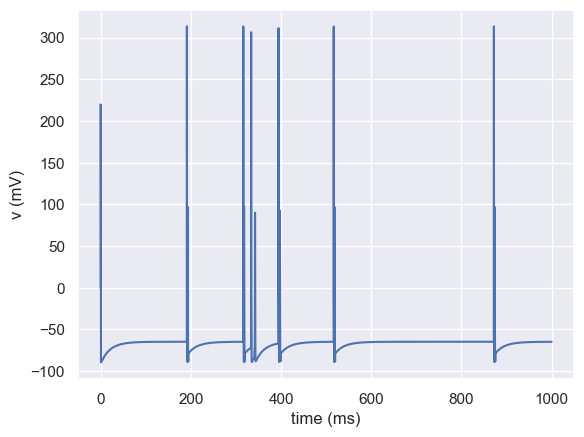

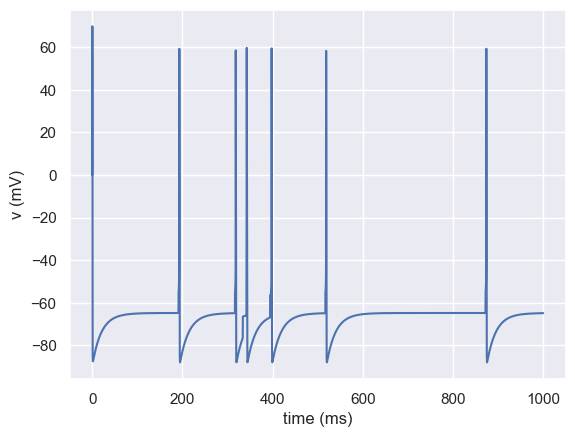

Top 10 lines
#1: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\copy.py:88: 1387.0 KiB
    return copier(x)
#2: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\caching.py:126: 824.0 KiB
    return tuple(_hashable(el) for el in obj)
#3: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\caching.py:37: 718.2 KiB
    return tuple(value for key, value in sorted(self.__dict__.items())
#4: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\templates.py:45: 651.8 KiB
    return '\n'.join(outlines)
#5: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:241: 550.2 KiB
    return compile(code, '(string)', 'exec')
#6: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:248: 508.1 KiB
    exec(compiled_code, self.namespace)
#7: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\sympy\core\facts.py:493: 487.1 KiB
    

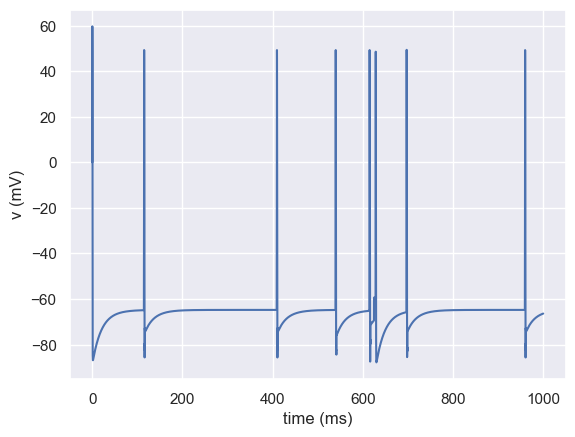

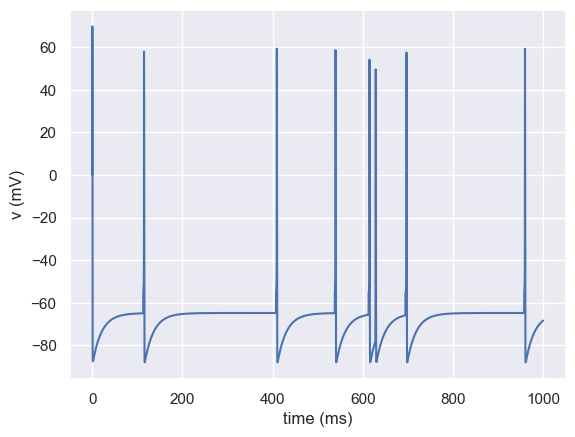

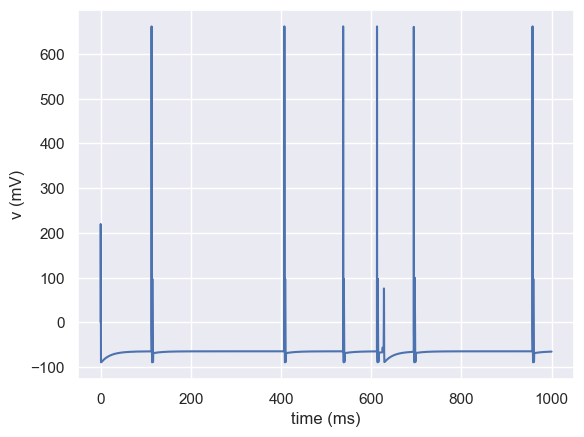

Top 10 lines
#1: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\copy.py:88: 2644.3 KiB
    return copier(x)
#2: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\templates.py:45: 1248.9 KiB
    return '\n'.join(outlines)
#3: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:241: 1033.1 KiB
    return compile(code, '(string)', 'exec')
#4: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:248: 966.5 KiB
    exec(compiled_code, self.namespace)
#5: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\core\tracking.py:20: 806.1 KiB
    wr = ref(value, self.remove)
#6: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\caching.py:126: 547.8 KiB
    return tuple(_hashable(el) for el in obj)
#7: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\stringtools.py:244: 542.7 KiB
    code = code.copy()
#8: C:\Us

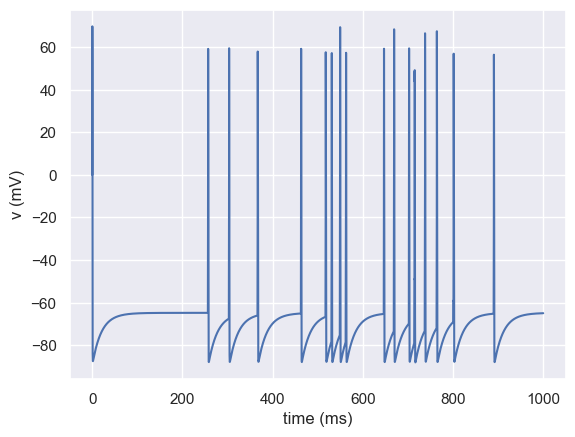

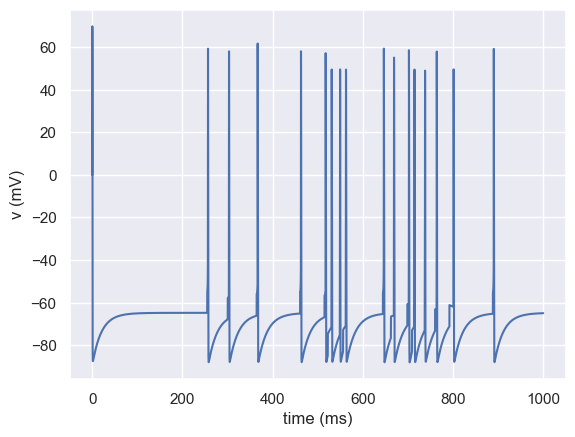

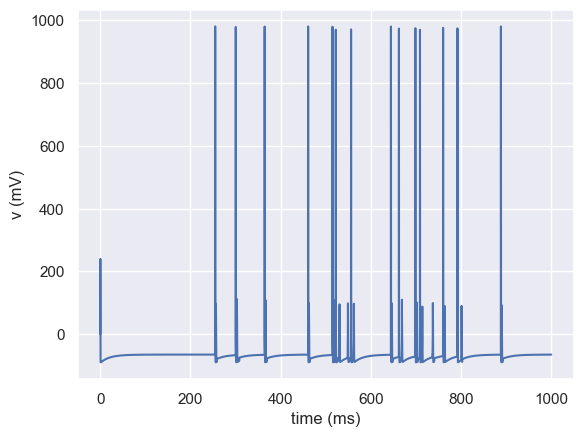

Top 10 lines
#1: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\copy.py:88: 4731.4 KiB
    return copier(x)
#2: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\templates.py:45: 2090.6 KiB
    return '\n'.join(outlines)
#3: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:241: 1772.9 KiB
    return compile(code, '(string)', 'exec')
#4: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:248: 1678.4 KiB
    exec(compiled_code, self.namespace)
#5: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\core\tracking.py:20: 1408.7 KiB
    wr = ref(value, self.remove)
#6: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\caching.py:126: 1331.3 KiB
    return tuple(_hashable(el) for el in obj)
#7: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\stringtools.py:244: 951.1 KiB
    code = code.copy()
#8: C:

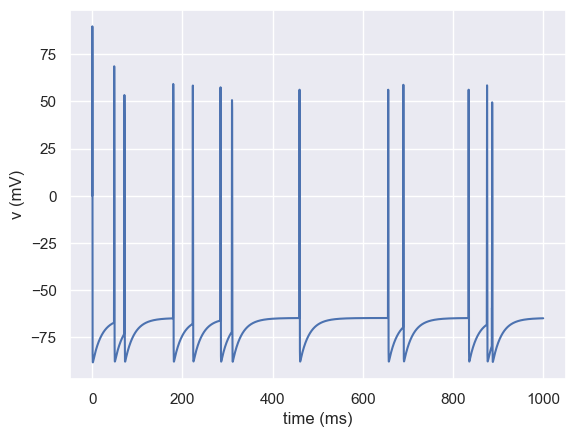

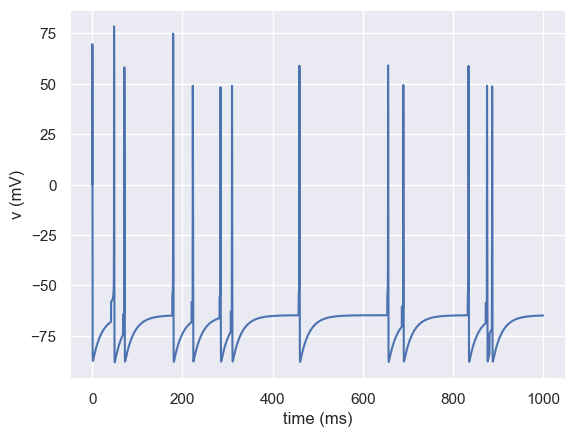

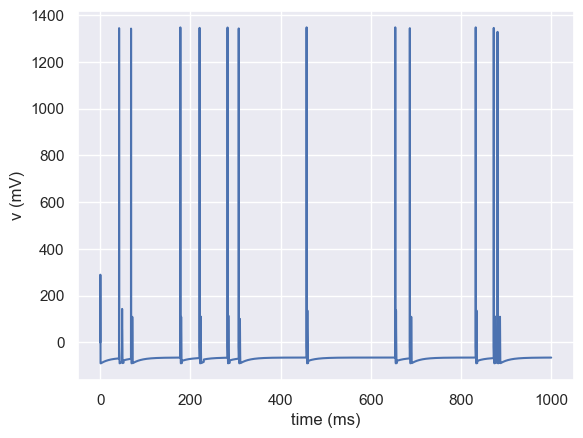

Top 10 lines
#1: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\copy.py:88: 6984.7 KiB
    return copier(x)
#2: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\templates.py:45: 3008.4 KiB
    return '\n'.join(outlines)
#3: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:241: 2470.7 KiB
    return compile(code, '(string)', 'exec')
#4: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:248: 2452.6 KiB
    exec(compiled_code, self.namespace)
#5: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\core\tracking.py:20: 2051.5 KiB
    wr = ref(value, self.remove)
#6: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\stringtools.py:244: 1394.4 KiB
    code = code.copy()
#7: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\parsing\rendering.py:124: 698.2 KiB
    return self.render_node(node)
#8: C:\Users\N

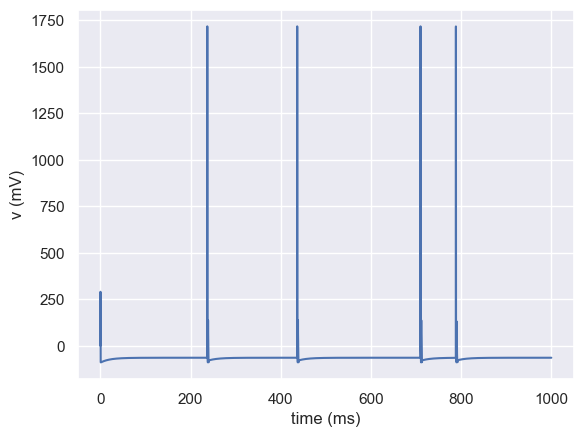

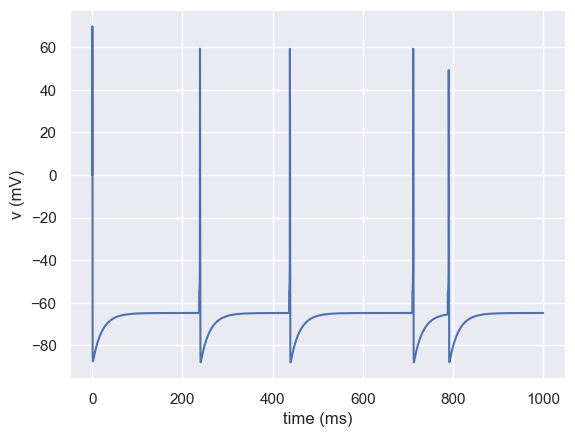

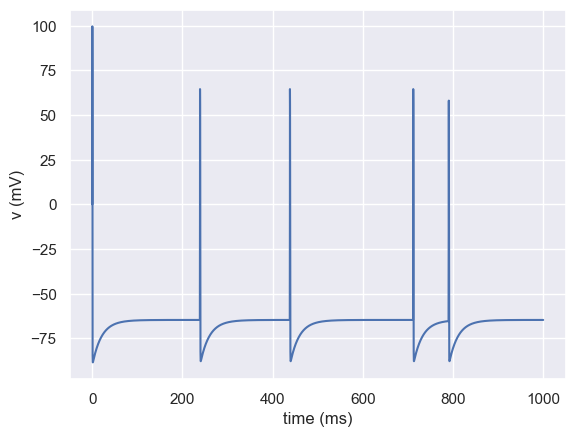

Top 10 lines
#1: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\copy.py:88: 9631.2 KiB
    return copier(x)
#2: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\templates.py:45: 4056.0 KiB
    return '\n'.join(outlines)
#3: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:241: 3415.8 KiB
    return compile(code, '(string)', 'exec')
#4: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:248: 3348.6 KiB
    exec(compiled_code, self.namespace)
#5: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\core\tracking.py:21: 3072.0 KiB
    set.add(self, wr)
#6: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\core\tracking.py:20: 2801.8 KiB
    wr = ref(value, self.remove)
#7: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\stringtools.py:244: 1911.7 KiB
    code = code.copy()
#8: C:\Users\NJPar\anaconda3\e

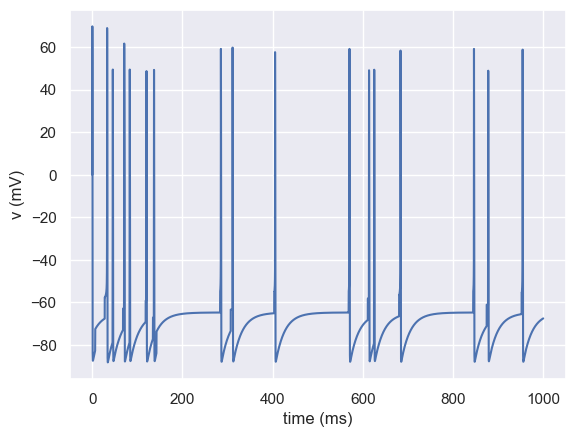

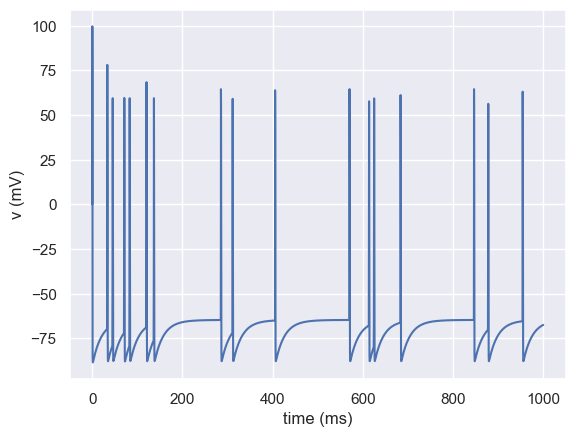

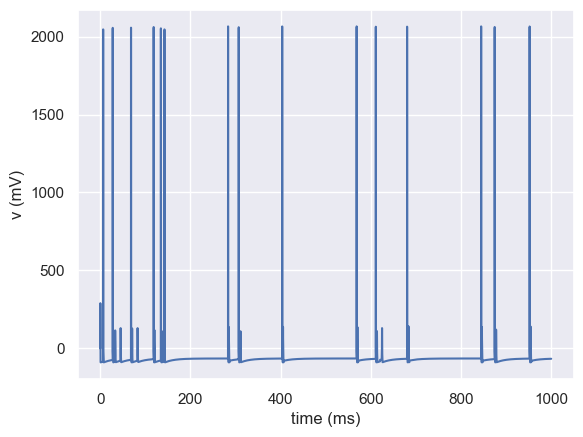

Top 10 lines
#1: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\copy.py:88: 12055.1 KiB
    return copier(x)
#2: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\templates.py:45: 5015.0 KiB
    return '\n'.join(outlines)
#3: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:241: 4221.2 KiB
    return compile(code, '(string)', 'exec')
#4: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\codegen\runtime\numpy_rt\numpy_rt.py:248: 4171.4 KiB
    exec(compiled_code, self.namespace)
#5: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\core\tracking.py:20: 3491.3 KiB
    wr = ref(value, self.remove)
#6: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\utils\stringtools.py:244: 2387.5 KiB
    code = code.copy()
#7: C:\Users\NJPar\anaconda3\envs\flybrainlab\lib\site-packages\brian2\parsing\rendering.py:124: 1223.8 KiB
    return self.render_node(node)
#8: C:\Users

In [11]:
cell_vars = {'area': -20000*umetre**2,
             'Cm': 1*ufarad*cm**-2 * 20000*umetre**2,
             'gl': 5e-5*siemens*cm**-2 * 20000*umetre**2,
             'El': -65*mV,
             'EK': -90*mV,
             'ENa': 50*mV,
             'g_na': 100*msiemens*cm**-2 * 20000*umetre**2,
             'g_kd': 30*msiemens*cm**-2 * 20000*umetre**2,
             'VT': -63*mV,
             'tau1': 0.1*ms,
             'tau2': 0.2*ms,
             'e': 0}

# Typical equations
neuron_eqs = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''

syn_onpre = '''
v += 10*mV
'''

stim_dict = {'model': 'rates = 10*Hz : Hz', 'threshold': 'rand()<rates*dt'}

my_client = fbl.get_client()

for i, query in enumerate(queries):
    res = my_client.executeNLPquery(query)
    
    networkParameters = toBri.model_gen(client=my_client,
                                        res=res,
                                        stim_sources={'bkg': stim_dict},
                                        stim_targets={'bkg': 'Mi4_C'},
                                        default_mech = {'on_pre': syn_onpre},
                                        default_cell = {'model': neuron_eqs, 'threshold': 'v > -40*mV', 'refractory': 'v > -40*mV', 'method':'exponential_euler'},
                                        record_names = ['Mi4-C', 'C2-C', 'L2-C'],
                                        maintain_morphology=False,
                                        **cell_vars)
    
    print("Simulating query: " + query)
    
    start_time = time.time()
    tracemalloc.start()

    toBri.simulate(networkParameters, 1000, cell_vars)

    snapshot = tracemalloc.take_snapshot()
    display_top(snapshot)

    tracemalloc.stop()

    print("--- %s seconds ---" % (time.time() - start_time))